In [73]:
"""
Brain-Computer Interface MLP Classifier
For EEG signal relaxation/focus state classification
USE RAW DATA AS INPUT
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import os
import glob
import warnings

warnings.filterwarnings('ignore')

from scipy.signal import welch, butter, filtfilt
from scipy.stats import skew, kurtosis

In [74]:
# Parameter Settings
class Config:
    # Dataset path settings
    DATASET_PATH = "bci_dataset_113-2"
    
    # MLP model parameters
    HIDDEN_LAYERS = (32, 4)
    MAX_ITER = 60
    LEARNING_RATE = 0.005
    ALPHA = 0.001
    ACTIVATION = 'relu'
    SOLVER = 'adam'
    BATCH_SIZE = 32
    EARLY_STOPPING = True
    VALIDATION_FRACTION = 0.1
    N_ITER_NO_CHANGE = 10
    
    # Signal processing parameters
    SAMPLING_RATE = 500
    SEGMENT_LENGTH = 5
    OVERLAP_RATIO = 0.5 #0.0 ~ 0.8
    
    # Feature selection parameters
    FEATURE_SELECTION = True
    # NOTE: When using raw data, N_FEATURES_SELECT will select the top N time points from the segment.
    # The number of features is now the number of samples in a segment (SEGMENT_LENGTH * SAMPLING_RATE).
    # You may want to adjust this value or disable feature selection.
    N_FEATURES_SELECT = 11
    
    # Other settings
    RANDOM_STATE = 42


In [75]:
class FeatureExtractor:
    def __init__(self, fs):
        self.fs = fs
        # 頻帶(Hz)
        self.bands = {
            "delta": (0.5, 4),
            "theta": (4, 8),
            "alpha": (8, 13),
            "beta":  (13, 30),
            "gamma": (30, 45)
        }
        self.feature_names = self._build_feature_names()
        
        #=======student code=====
        # 設計帶通濾波器 (0.5-45 Hz)
        self.filter_low = 0.5
        self.filter_high = 45
        self.filter_order = 4
        self.b, self.a = butter(self.filter_order, 
                               [self.filter_low, self.filter_high], 
                               btype='band', fs=self.fs)
        #=======student code=====
    
    def _build_feature_names(self):
        names = []
        # 絕對與相對頻帶能量
        for b in self.bands.keys():
            names.append(f"bp_{b}_abs")
        for b in self.bands.keys():
            names.append(f"bp_{b}_rel")
        # 比值
        names += ["ratio_alpha_theta", "ratio_beta_alpha"]
        # Hjorth
        names += ["hj_activity", "hj_mobility", "hj_complexity"]
        # 時域統計
        names += ["mean", "std", "skew", "kurtosis", "rms", "zcr"]
        # 頻譜熵
        names += ["spectral_entropy"]
        return names

    def _bandpower(self, x):
        # Welch 功率譜
        f, Pxx = welch(x, fs=self.fs, nperseg=min(len(x), 512))
        total_power = np.trapz(Pxx, f) + 1e-12
        band_abs = {}
        band_rel = {}
        for name, (lo, hi) in self.bands.items():
            idx = np.logical_and(f >= lo, f < hi)
            power = np.trapz(Pxx[idx], f[idx])
            band_abs[name] = power
            band_rel[name] = power / total_power
        return band_abs, band_rel

    def _hjorth(self, x):
        # Hjorth 參數
        x = np.asarray(x)
        dx = np.diff(x, prepend=x[0])
        ddx = np.diff(dx, prepend=dx[0])
        var0 = np.var(x) + 1e-12
        var1 = np.var(dx) + 1e-12
        var2 = np.var(ddx) + 1e-12
        activity = var0
        mobility = np.sqrt(var1 / var0)
        complexity = np.sqrt(var2 / var1) / (mobility + 1e-12)
        return activity, mobility, complexity

    def _zcr(self, x):
        x = np.asarray(x)
        return np.mean(np.abs(np.diff(np.sign(x)))) / 2.0

    def _spectral_entropy(self, x):
        f, Pxx = welch(x, fs=self.fs, nperseg=min(len(x), 512))
        psd = Pxx + 1e-12
        psd = psd / psd.sum()
        return -np.sum(psd * np.log(psd))

    def extract_features(self, segment):
        #=======student code=====
        # 應用帶通濾波器
        filtered_segment = filtfilt(self.b, self.a, segment)
        #=======student code=====
        
        band_abs, band_rel = self._bandpower(filtered_segment)
        activity, mobility, complexity = self._hjorth(filtered_segment)
        feats = []
        # 絕對與相對頻帶能量
        for name in self.bands.keys():
            feats.append(band_abs[name])
        for name in self.bands.keys():
            feats.append(band_rel[name])
        # 比值
        alpha = band_abs["alpha"] + 1e-12
        theta = band_abs["theta"] + 1e-12
        beta  = band_abs["beta"]  + 1e-12
        feats.append(alpha / theta)  # alpha/theta
        feats.append(beta / alpha)   # beta/alpha
        # Hjorth
        feats += [activity, mobility, complexity]
        # 時域統計
        x = np.asarray(filtered_segment)
        feats += [np.mean(x), np.std(x), skew(x), kurtosis(x), np.sqrt(np.mean(x**2)), self._zcr(x)]
        # 頻譜熵
        feats += [self._spectral_entropy(x)]

        y = [ alpha/(alpha+beta+theta),beta/(alpha+theta),alpha/(beta+theta),activity, mobility, complexity, np.mean(x), np.std(x), skew(x), kurtosis(x), np.sqrt(np.mean(x**2)), self._zcr(x), self._spectral_entropy(x)]

        return np.array(y, dtype=float)

In [76]:

# Data Loading and Processing
def load_eeg_data(subject_path):
    """Load EEG data for a single subject"""
    relax_file = os.path.join(subject_path, "1.txt")
    focus_file = os.path.join(subject_path, "2.txt")
    
    try:
        relax_data = np.loadtxt(relax_file)
        focus_data = np.loadtxt(focus_file)
        return relax_data, focus_data
    except Exception as e:
        print(f"Error loading data for {subject_path}: {e}")
        return None, None

def create_segments(data, segment_length_samples, overlap_samples):
    """Split continuous EEG signal into multiple segments"""
    if len(data) < segment_length_samples:
        return np.array([]) # Return empty array if not enough data for one segment
    
    segments = []
    start = 0
    step = segment_length_samples - overlap_samples
    
    while start + segment_length_samples <= len(data):
        segment = data[start:start + segment_length_samples]
        segments.append(segment)
        start += step
    
    return np.array(segments[70:-80])


In [77]:

# Model Definition and Training
class EnhancedBCIClassifier:
    """Enhanced Brain-Computer Interface Classifier"""
    
    def __init__(self):
        self.model = MLPClassifier(
            hidden_layer_sizes=Config.HIDDEN_LAYERS,
            max_iter=Config.MAX_ITER,
            learning_rate_init=Config.LEARNING_RATE,
            alpha=Config.ALPHA,
            activation=Config.ACTIVATION,
            solver=Config.SOLVER,
            batch_size=Config.BATCH_SIZE,
            early_stopping=Config.EARLY_STOPPING,
            validation_fraction=Config.VALIDATION_FRACTION,
            n_iter_no_change=Config.N_ITER_NO_CHANGE,
            random_state=Config.RANDOM_STATE,
            verbose=False
        )
        self.scaler = StandardScaler()
        # The number of features k should be less than or equal to the number of samples in a segment
        num_features = Config.SAMPLING_RATE * Config.SEGMENT_LENGTH
        k_features = min(Config.N_FEATURES_SELECT, num_features)
        
        self.feature_selector = SelectKBest(f_classif, k=k_features) if Config.FEATURE_SELECTION else None
        
    def fit(self, X, y):
        """Train the model"""
        # Standardization
        X_scaled = self.scaler.fit_transform(X)
        
        # Feature selection
        if self.feature_selector is not None:
            X_selected = self.feature_selector.fit_transform(X_scaled, y)
        else:
            X_selected = X_scaled
        
        # Train the model
        self.model.fit(X_selected, y)
        return self
    
    def predict(self, X):
        """Make predictions"""
        X_scaled = self.scaler.transform(X)
        
        if self.feature_selector is not None:
            X_selected = self.feature_selector.transform(X_scaled)
        else:
            X_selected = X_scaled
            
        return self.model.predict(X_selected)
    
    def get_loss_curve(self):
        """Get the loss curve"""
        if hasattr(self.model, 'loss_curve_'):
            return self.model.loss_curve_
        else:
            return []


In [78]:

# Main Execution Functions
def load_all_subjects():
    """Load data from all subjects"""
    all_features = []
    all_labels = []
    all_subjects = []
    
    # Find all subject folders
    subject_folders = sorted(glob.glob(os.path.join(Config.DATASET_PATH, "S*")))
    
    if not subject_folders:
        print(f"Error: No subject folders found in {Config.DATASET_PATH}")
        return None, None, None
    
    #======student code======
    fe = FeatureExtractor(fs=Config.SAMPLING_RATE)
    #======student code======


    for subject_folder in subject_folders:
        subject_id = os.path.basename(subject_folder)
        
        # Load data
        relax_data, focus_data = load_eeg_data(subject_folder)
        
        if relax_data is None or focus_data is None:
            continue

        # Create signal segments from raw data to be used as input features
        segment_length_samples = int(Config.SEGMENT_LENGTH * Config.SAMPLING_RATE)
        overlap_samples = int(segment_length_samples * Config.OVERLAP_RATIO)
    
        relax_segments = create_segments(relax_data, segment_length_samples, overlap_samples)
        focus_segments = create_segments(focus_data, segment_length_samples, overlap_samples)
        
        # Check if segments were created successfully
        if relax_segments.size == 0 or focus_segments.size == 0:
            print(f"Warning: Not enough data to create segments for {subject_id}. Skipping this subject.")
            continue
            
        # Extract features from segments
        #======student code======
        # 對原始信號也應用濾波器
        relax_filtered = np.array([filtfilt(fe.b, fe.a, seg) for seg in relax_segments])
        focus_filtered = np.array([filtfilt(fe.b, fe.a, seg) for seg in focus_segments])
        
        relax_features = np.vstack([fe.extract_features(seg) for seg in relax_segments])
        focus_features = np.vstack([fe.extract_features(seg) for seg in focus_segments])
        
        # Concatenate features with filtered segments
        relax_combined = np.hstack([relax_filtered, relax_features])
        focus_combined = np.hstack([focus_filtered, focus_features])
        #======student code======
    
        # Label data
        relax_labels = np.zeros(len(relax_combined))  # 0 = relax
        focus_labels = np.ones(len(focus_combined))   # 1 = focus
        
        # Combine data
        subject_features = np.vstack([relax_combined, focus_combined])
        subject_labels = np.hstack([relax_labels, focus_labels])
        
        # Record subject IDs
        subject_ids = [subject_id] * len(subject_labels)
        
        all_features.append(subject_features)
        all_labels.append(subject_labels)
        all_subjects.extend(subject_ids)
    
    if not all_features:
        print("Error: No valid data found")
        return None, None, None
    
    # Combine all data
    X = np.vstack(all_features)
    y = np.hstack(all_labels)

    return X, y, all_subjects


In [79]:

def leave_one_subject_out_validation():
    """Perform Leave-One-Subject-Out cross-validation"""
    print("Starting Leave-One-Subject-Out Cross-Validation with RAW DATA...")
    
    # Load all data
    X, y, subjects = load_all_subjects()
    
    if X is None:
        return None
    
    # Get unique subject list
    unique_subjects = sorted(list(set(subjects)))
    
    # Store results
    results = {
        'accuracies': [],
        'confusion_matrices': [],
        'loss_curves': [],
        'subject_names': []
    }
    
    # Test each subject
    for test_subject in unique_subjects:
        # Split training and test sets
        train_mask = [s != test_subject for s in subjects]
        test_mask = [s == test_subject for s in subjects]
        
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        
        # Train model
        classifier = EnhancedBCIClassifier()
        classifier.fit(X_train, y_train)
        
        # Predict
        y_pred = classifier.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        
        # Store results
        results['accuracies'].append(accuracy)
        results['confusion_matrices'].append(cm)
        results['loss_curves'].append(classifier.get_loss_curve())
        results['subject_names'].append(test_subject)
        
        print(f"{test_subject}: Accuracy = {accuracy:.3f}")
    
    return results


In [80]:

def plot_results(results):
    """Plot result charts"""
    if results is None:
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('BCI Classifier (Raw Data) - LOSO Cross-Validation Results', fontsize=16)
    
    # 1. Accuracy distribution
    axes[0].bar(range(len(results['accuracies'])), results['accuracies'], 
                color=['green' if acc >= 0.7 else 'orange' if acc >= 0.6 else 'red' 
                       for acc in results['accuracies']])
    axes[0].set_title('Accuracy by Subject')
    axes[0].set_xlabel('Subject Index')
    axes[0].set_ylabel('Accuracy')
    axes[0].axhline(y=np.mean(results['accuracies']), color='r', linestyle='--', 
                    label=f'Mean: {np.mean(results["accuracies"]):.3f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1)
    
    # 2. Overall confusion matrix
    total_cm = np.sum(results['confusion_matrices'], axis=0)
    sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Relax', 'Focus'],
                yticklabels=['Relax', 'Focus'],
                ax=axes[1])
    axes[1].set_title('Overall Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    # 3. Training loss curves
    valid_loss_curves = [lc for lc in results['loss_curves'] if len(lc) > 0]
    if valid_loss_curves:
        for i, loss_curve in enumerate(valid_loss_curves[:5]):  # Show first 5
            axes[2].plot(loss_curve, alpha=0.7, label=f'S{i+1}')
        axes[2].set_title('Training Loss Curves (First 5 Subjects)')
        axes[2].set_xlabel('Iteration')
        axes[2].set_ylabel('Loss')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'No loss curves available', 
                     horizontalalignment='center', verticalalignment='center',
                     transform=axes[2].transAxes)
        axes[2].set_title('Training Loss Curves')
    
    plt.tight_layout()
    #plt.savefig('bci_results_raw_data.png', dpi=300, bbox_inches='tight')
    plt.show()


BCI EEG Classification (Raw Data Input) - Relaxation vs Concentration
Starting Leave-One-Subject-Out Cross-Validation with RAW DATA...
S02: Accuracy = 0.500
S03: Accuracy = 0.364
S04: Accuracy = 0.848
S05: Accuracy = 0.957
S06: Accuracy = 0.900
S07: Accuracy = 0.889
S08: Accuracy = 0.727
S09: Accuracy = 0.727
S10: Accuracy = 0.583
S11: Accuracy = 0.861
S12: Accuracy = 0.727
S13: Accuracy = 0.696
S14: Accuracy = 0.682
S15: Accuracy = 0.750
S16: Accuracy = 0.781
S17: Accuracy = 0.696
S18: Accuracy = 0.591

Overall Mean Accuracy: 0.722 ± 0.148

Relax Class:
  - Accuracy (Recall): 0.784 (167/213)
  - Precision: 0.705 (167/237)

Concentration Class:
  - Accuracy (Recall): 0.693 (158/228)
  - Precision: 0.775 (158/204)


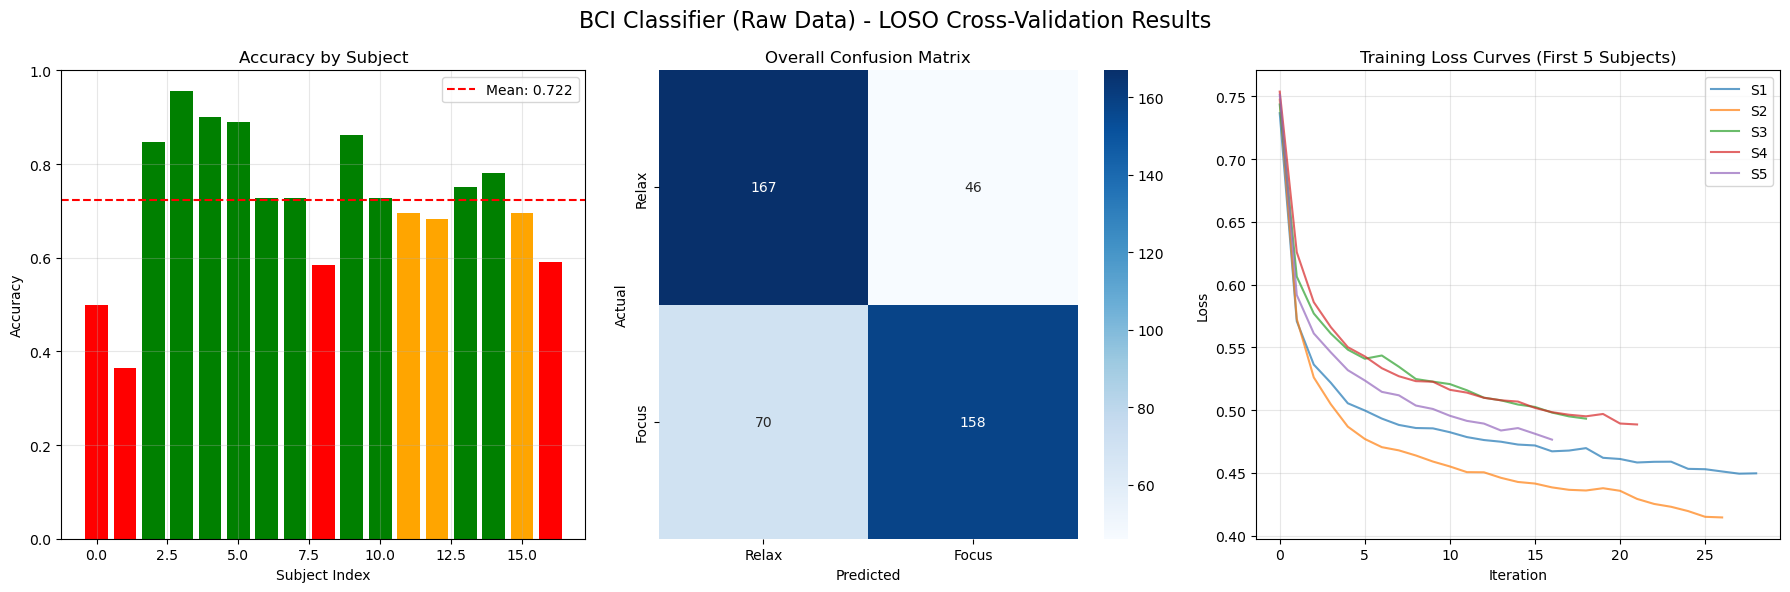


Results saved to 'bci_results_raw_data.png'


In [81]:
print("BCI EEG Classification (Raw Data Input) - Relaxation vs Concentration")
print("=" * 60)

# Perform Leave-One-Subject-Out validation
results = leave_one_subject_out_validation()

if results is None:
    print("Validation failed!")

# Display overall results
mean_accuracy = np.mean(results['accuracies'])
std_accuracy = np.std(results['accuracies'])

print(f"\nOverall Mean Accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")

# Calculate and display accuracy for each class
total_cm = np.sum(results['confusion_matrices'], axis=0)

with np.errstate(divide='ignore', invalid='ignore'):
    # Calculate accuracy (Recall) for each class
    relax_accuracy = total_cm[0, 0] / np.sum(total_cm[0, :]) if np.sum(total_cm[0, :]) > 0 else 0
    concentration_accuracy = total_cm[1, 1] / np.sum(total_cm[1, :]) if np.sum(total_cm[1, :]) > 0 else 0
    
    # Calculate precision for each class
    relax_precision = total_cm[0, 0] / np.sum(total_cm[:, 0]) if np.sum(total_cm[:, 0]) > 0 else 0
    concentration_precision = total_cm[1, 1] / np.sum(total_cm[:, 1]) if np.sum(total_cm[:, 1]) > 0 else 0

print(f"\nRelax Class:")
print(f"  - Accuracy (Recall): {relax_accuracy:.3f} ({total_cm[0, 0]}/{np.sum(total_cm[0, :])})")
print(f"  - Precision: {relax_precision:.3f} ({total_cm[0, 0]}/{np.sum(total_cm[:, 0])})")

print(f"\nConcentration Class:")
print(f"  - Accuracy (Recall): {concentration_accuracy:.3f} ({total_cm[1, 1]}/{np.sum(total_cm[1, :])})")
print(f"  - Precision: {concentration_precision:.3f} ({total_cm[1, 1]}/{np.sum(total_cm[:, 1])})")

# Plot results
plot_results(results)

print(f"\nResults saved to 'bci_results_raw_data.png'")